In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import dataframe_image as dfi
import matplotlib.ticker as mtick
%matplotlib inline




In [121]:
bitcoin_tweets_df = pd.read_csv("./Resources/df_Final.csv", sep=';')
bitcoin_tweets_df.head(2)


,Date,Compound_Score,Total Volume of Tweets,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Count_News,Count_Bots,Open,High,Low,Close,Volume (BTC),"Volume (Currency),,"
0,2017-08-01 00:00:00,0.08,"1,027.00",139.00,347.00,397.00,-0.52,0.42,695.00,144.00,"2,855.81","2,863.06","2,823.00","2,825.92",184.02,"522951,0,"
1,2017-08-01 01:00:00,0.05,778.00,111.00,193.00,320.00,-0.42,0.42,493.00,154.00,"2,823.01","2,860.02","2,821.01","2,853.38",77.3,"219605.16,,"


In [122]:
# get end of day price and tweet count
end_price = bitcoin_tweets_df[bitcoin_tweets_df['Date'].str.contains('23:00:00')]


In [123]:
end_price.head(1)


,Date,Compound_Score,Total Volume of Tweets,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Count_News,Count_Bots,Open,High,Low,Close,Volume (BTC),"Volume (Currency),,"
23,2017-08-01 23:00:00,0.03,"1,282.00",212.00,244.00,569.00,-0.36,0.43,887.00,257.00,"2,699.93","2,733.05","2,691.37","2,731.00",268.66,"729341.39,,"


In [124]:
end_price['Close']



23      2,731.00
47      2,703.51
71      2,793.37
95      2,855.00
119     3,263.62
          ...   
12839   3,682.51
12863   3,647.29
12887   3,732.40
12911   3,568.27
12935   3,573.67
Name: Close, Length: 539, dtype: float64

In [125]:
# remove ',,' and ',0,' from volume in dollars column
bitcoin_tweets_df['Volume (Currency),,'] = bitcoin_tweets_df['Volume (Currency),,'].str.replace(',,', ' ')
bitcoin_tweets_df['Volume (Currency),,'] = bitcoin_tweets_df['Volume (Currency),,'].str.replace(',0,', ' ')

In [126]:
bitcoin_tweets_df[['Date', 'Time']] = bitcoin_tweets_df['Date'].str.split(' ', expand=True)

In [127]:
# get end of day closing price 
end_of_day = bitcoin_tweets_df[bitcoin_tweets_df['Time'].str.contains('23:00:00')]

In [128]:
end_of_day.head(1)

,Date,Compound_Score,Total Volume of Tweets,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Count_News,Count_Bots,Open,High,Low,Close,Volume (BTC),"Volume (Currency),,",Time
23,2017-08-01,0.03,"1,282.00",212.00,244.00,569.00,-0.36,0.43,887.00,257.00,"2,699.93","2,733.05","2,691.37","2,731.00",268.66,729341.39,23:00:00


In [129]:
total_negative = bitcoin_tweets_df.groupby('Date')['Count_Negatives'].sum()
total_positive = bitcoin_tweets_df.groupby('Date')['Count_Positives'].sum()
total_neutral = bitcoin_tweets_df.groupby('Date')['Count_Neutrals'].sum()
close_price = end_of_day.set_index('Date')['Close']
tweet_vol = bitcoin_tweets_df.groupby('Date')['Total Volume of Tweets'].sum()
date = bitcoin_tweets_df['Date'].unique()


tweets_dict = {'Closing Price': close_price, 
               'Positive Tweets': total_positive, 
               'Negative Tweets': total_negative, 
               'Neutral Tweets': total_neutral, 
               'Total Volume of Tweets': tweet_vol}

tweets_df = pd.DataFrame(tweets_dict)
tweets_df.tail(2)

,Closing Price,Positive Tweets,Negative Tweets,Neutral Tweets,Total Volume of Tweets
Date,,,,,
2019-01-20,"3,568.27","5,856.00","2,928.00","5,292.00","17,645.00"
2019-01-21,"3,573.67","7,321.00","3,671.00","6,783.00","21,341.00"


In [130]:
btc_usdDF = pd.read_csv("./Resources/BTC-USD.csv")
btc_usdDF.head(3)

,Date,Volume
0,8/1/2017,"1,324,669,952.00"
1,8/2/2017,"1,094,950,016.00"
2,8/3/2017,"804,796,992.00"


In [131]:
btc_usdDF['Volume'].astype(float)

0     1,324,669,952.00
1     1,094,950,016.00
2       804,796,992.00
3     1,002,120,000.00
4     1,945,699,968.00
            ...       
534   5,464,420,383.00
535   5,002,961,726.00
536   5,955,691,379.00
537   5,582,489,559.00
538   5,004,347,059.00
Name: Volume, Length: 539, dtype: float64

In [132]:
tweets_df['Volume'] = list(btc_usdDF['Volume'])

In [133]:


tweets_df['Volume'].astype(float)

Date
2017-08-01   1,324,669,952.00
2017-08-02   1,094,950,016.00
2017-08-03     804,796,992.00
2017-08-04   1,002,120,000.00
2017-08-05   1,945,699,968.00
                   ...       
2019-01-17   5,464,420,383.00
2019-01-18   5,002,961,726.00
2019-01-19   5,955,691,379.00
2019-01-20   5,582,489,559.00
2019-01-21   5,004,347,059.00
Name: Volume, Length: 539, dtype: float64

In [134]:
tweets_df.head(3)

,Closing Price,Positive Tweets,Negative Tweets,Neutral Tweets,Total Volume of Tweets,Volume
Date,,,,,,
2017-08-01,"2,731.00","6,471.00","4,701.00","12,089.00","30,802.00","1,324,669,952.00"
2017-08-02,"2,703.51","4,734.00","2,732.00","9,063.00","23,726.00","1,094,950,016.00"
2017-08-03,"2,793.37","5,351.00","3,233.00","9,806.00","25,111.00","804,796,992.00"


In [135]:
tweets_df['Closing Price'] =tweets_df['Closing Price'].map('{:.2f}'.format )
tweets_df['Positive Tweets']=tweets_df['Positive Tweets'].map('{:.2f}'.format )
tweets_df['Negative Tweets']=tweets_df['Negative Tweets'].map('{:.2f}'.format )
tweets_df['Total Volume of Tweets']=tweets_df['Total Volume of Tweets'].map('{:.2f}'.format )
tweets_df['Neutral Tweets']=tweets_df['Neutral Tweets'].map('{:.2f}'.format )
tweets_df['Volume']=tweets_df['Volume'].map('{:.2f}'.format )

In [136]:
tweets_df.head(2)

,Closing Price,Positive Tweets,Negative Tweets,Neutral Tweets,Total Volume of Tweets,Volume
Date,,,,,,
2017-08-01,2731.00,6471.00,4701.00,12089.00,30802.00,1324669952.00
2017-08-02,2703.51,4734.00,2732.00,9063.00,23726.00,1094950016.00


In [137]:
tweets_df['Volume'] =tweets_df['Volume'].astype(float)
tweets_df['Negative Tweets'] = tweets_df['Negative Tweets'].astype(float)
tweets_df['Positive Tweets'] = tweets_df['Positive Tweets'].astype(float)
tweets_df['Neutral Tweets'] = tweets_df['Neutral Tweets'].astype(float)
tweets_df['Closing Price'] = tweets_df['Closing Price'].astype(float)

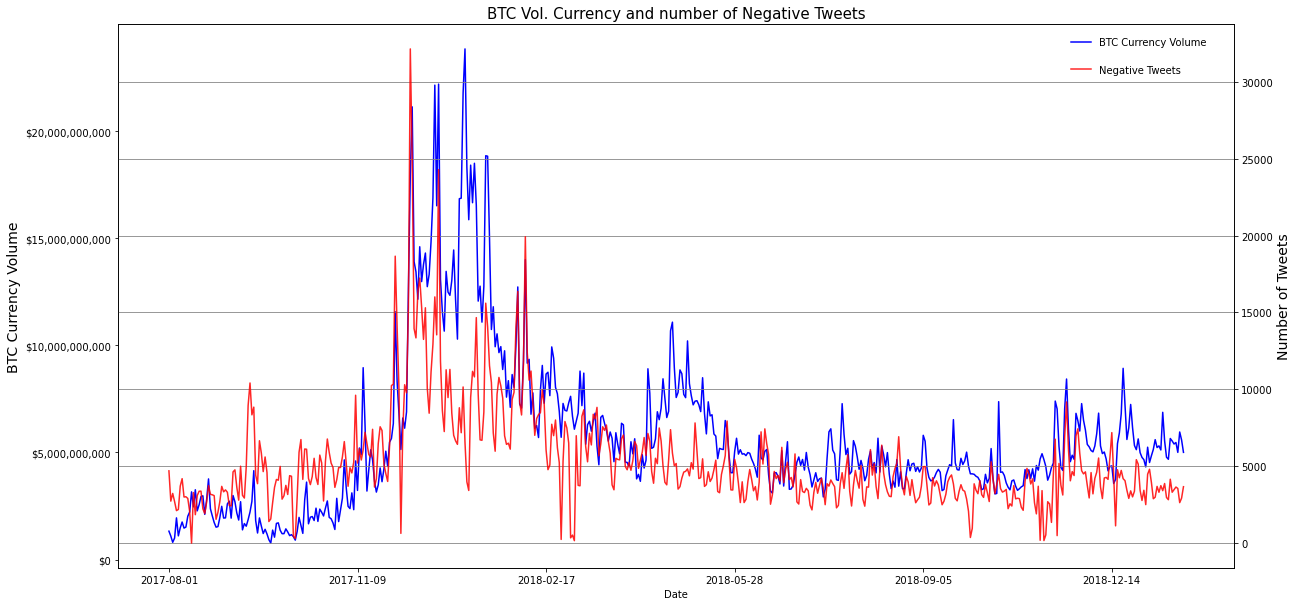

In [138]:
fig1,ax1 = plt.subplots()
ax1 = tweets_df['Volume'].plot(label='BTC Currency Volume', figsize=(20, 10),color="blue")
plt.title('BTC Vol. Currency and number of Negative Tweets', fontdict = {'fontsize':15})
yfmt = '${x:,.0f}'
yick = mtick.StrMethodFormatter(yfmt)
ax1.set_ylabel("BTC Currency Volume",color="black",fontsize=14)
ax1.yaxis.set_major_formatter(yick)
plt.legend()
ax2 = ax1.twinx()
ax2 = tweets_df['Negative Tweets'].plot(color = 'red', figsize=(20, 10),alpha = .85)
ax2.set_ylabel("Number of Tweets",color="black",fontsize=14)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.legend()
ax1.legend(loc = (.85,.95), frameon = False)
ax2.legend( loc = (.85, .9), frameon = False)
plt.grid(b=True, which='major', color='grey', linestyle='-')

plt.show()
fig1.savefig('Volume vs. Negative tweets.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')



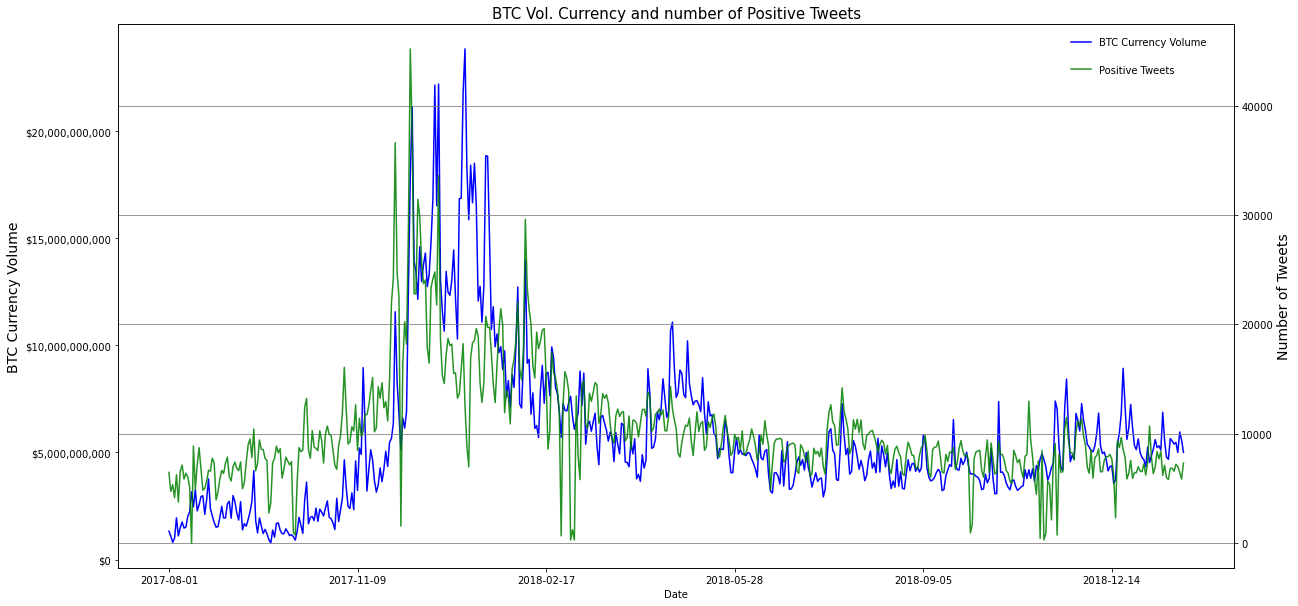

In [139]:
fig2,ax3 = plt.subplots()
ax3 = tweets_df['Volume'].plot(label='BTC Currency Volume', figsize=(16, 8),color="blue")
plt.title('BTC Vol. Currency and number of Positive Tweets', fontdict = {'fontsize':15})

yfmt = '${x:,.0f}'
yick = mtick.StrMethodFormatter(yfmt)

ax3.set_ylabel("BTC Currency Volume",color="black",fontsize=14)
ax3.yaxis.set_major_formatter(yick)
plt.legend()
ax4 = ax3.twinx()
ax4= tweets_df['Positive Tweets'].plot(label = 'Positive Tweets',color = 'green', figsize=(20, 10), alpha = .85)

ax4.set_ylabel("Number of Tweets",color="black",fontsize=14)

plt.legend()
ax3.legend(loc = (.85,.95), frameon = False)
ax4.legend( loc = (.85, .9), frameon = False)
plt.grid(b=True, which='major', color='grey', linestyle='-')

plt.show()
fig2.savefig('Volume vs. Positive tweets.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


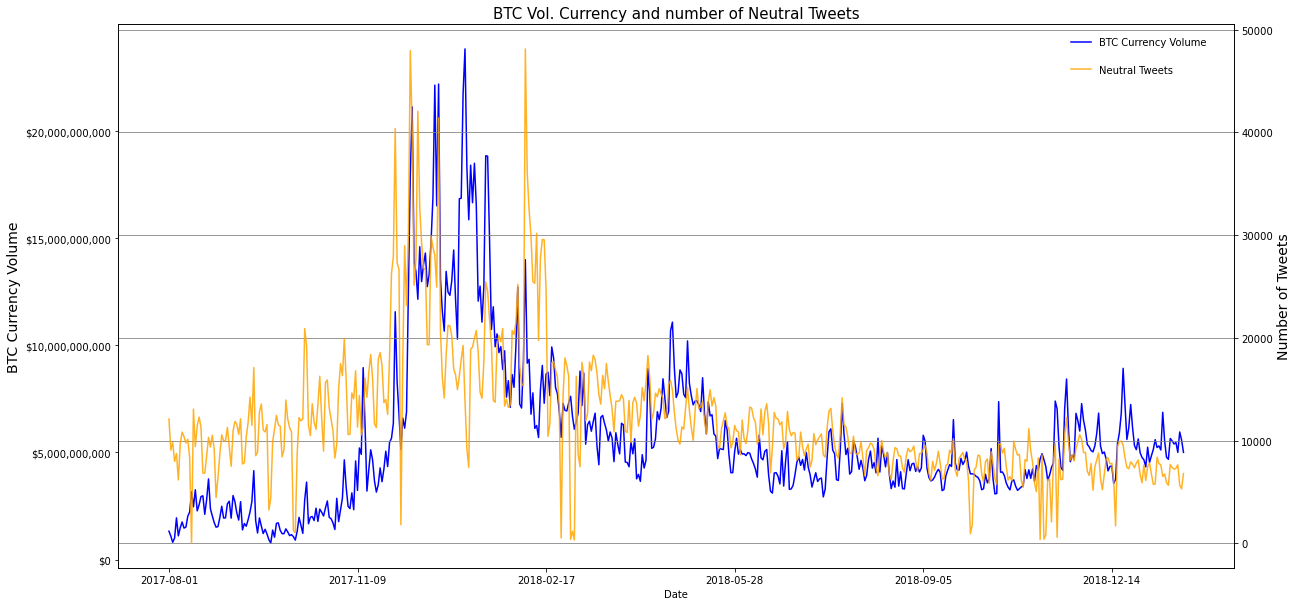

In [140]:
fig3, ax5 = plt.subplots()
ax5 = tweets_df['Volume'].plot(label='BTC Currency Volume', figsize=(16, 8),color="blue")
plt.title('BTC Vol. Currency and number of Neutral Tweets',fontdict = {'fontsize':15})
yfmt = '${x:,.0f}'
yick = mtick.StrMethodFormatter(yfmt)

ax5.set_ylabel("BTC Currency Volume",color="black",fontsize=14)
ax5.yaxis.set_major_formatter(yick)
plt.legend()
ax6 = ax5.twinx()
ax6 = tweets_df['Neutral Tweets'].plot(label = 'Neutral Tweets',color = 'orange', figsize=(20, 10), alpha = .85)

ax6.set_ylabel("Number of Tweets",color="black",fontsize=14)

plt.legend()
ax5.legend(loc = (.85,.95), frameon = False)
ax6.legend( loc = (.85, .9), frameon = False)
plt.grid(b=True, which='major', color='grey', linestyle='-')

plt.show()

fig3.savefig('Volume vs. Neutral tweets.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [146]:
ntweets_corr = tweets_df['Neutral Tweets'].corr(tweets_df['Volume'])
ptweets_corr = tweets_df['Positive Tweets'].corr(tweets_df['Volume'])
negtweets_corr = tweets_df['Negative Tweets'].corr(tweets_df['Volume'])
corr_df = pd.DataFrame.from_records([{'': 'Correlation', 'Neutral Tweets': ntweets_corr, 
                                      'Positive Tweets': ptweets_corr ,'Negative tweets':negtweets_corr}], index = 'Neutral Tweets')
                                      
pd.options.display.float_format = '{:,.2f}'.format
corr_df.reset_index().set_index('')



,Neutral Tweets,Positive Tweets,Negative tweets
,,,
Correlation,0.61,0.71,0.70


In [147]:

dfi.export(corr_df,"Correlation1.png")

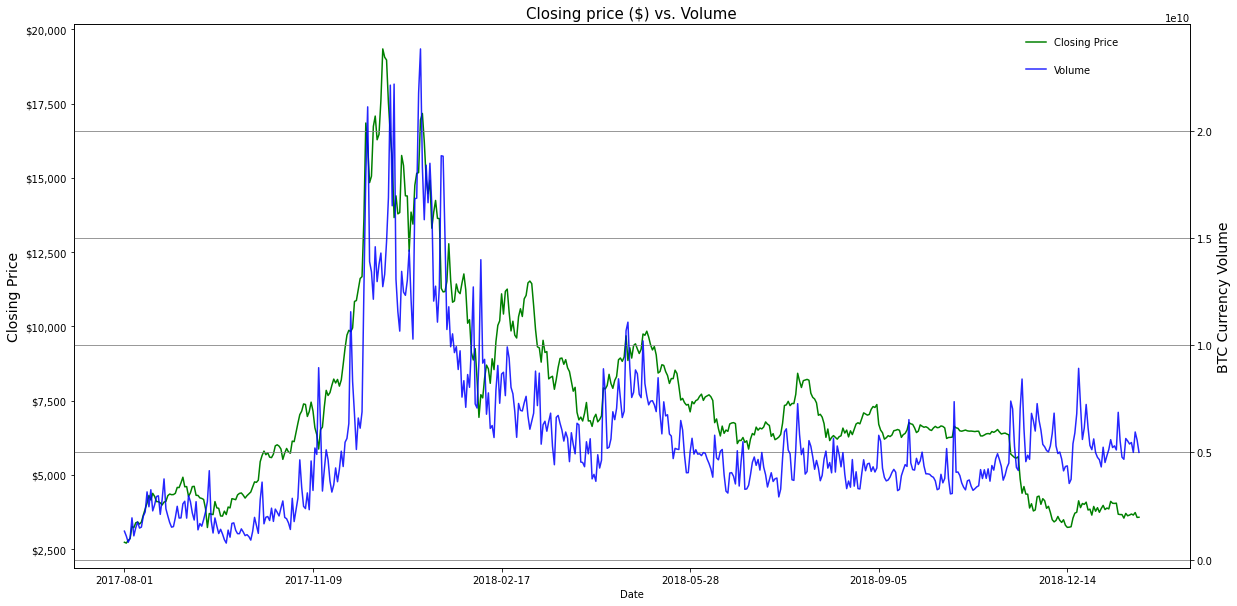

In [143]:
fig,ax7 = plt.subplots()
ax7 = tweets_df['Closing Price'].plot(label='Closing Price', figsize=(20, 10),color="green")#title=' Closing price vs. Volume')
plt.title('Closing price ($) vs. Volume', fontdict = {'fontsize': 15})
yfmt = '${x:,.0f}'
yick = mtick.StrMethodFormatter(yfmt)
ax7.set_ylabel("Closing Price",color="black",fontsize=14)
ax7.yaxis.set_major_formatter(yick)
plt.legend()
ax8 = ax7.twinx()
ax8 = tweets_df['Volume'].plot(color = 'blue', figsize=(20, 10),alpha=.85)
ax8.set_ylabel("BTC Currency Volume",color="black",fontsize=14)
plt.legend()
ax7.legend(loc = (.85,.95), frameon = False)
ax8.legend( loc = (.85, .9), frameon = False)
plt.grid(b=True, which='major', color='grey', linestyle='-')
correlation5 = tweets_df['Closing Price'].corr(tweets_df['Volume'])
plt.show()
fig.savefig('Closing price vs. Volume.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


In [144]:
correlation5

0.814151792844111

In [145]:
corr_df5 = pd.DataFrame.from_records([{'': 'Correlation', 'Closing price vs Volume': correlation5,} ],index = "Closing price vs Volume")
                                      
pd.options.display.float_format = '{:,.2f}'.format
corr_df5.reset_index().set_index('')


,Closing price vs Volume
,
Correlation,0.81
